In [1]:
import numpy as np
from IPython.display import Audio
import scipy.signal as sig
import soundfile as sf
import matplotlib.pyplot as plt
import mat73
import os
import masp as srs
from os.path import join as pjoin
import copy

In [2]:
# import my modules (helpers.py where I stored all the functions):
import helpers as hlp
import importlib
importlib.reload(hlp);

In [3]:
TARGET_ANGLE=30
target_snr = 5.
fs=48000
chunk_len = 30 #seconds
tag='normal' #change to inverse when running for the second time
speech_path = 'listening_situations_target_speech'
arte_path = '/home/ubuntu/Data/ARTE'
output_path = '/home/ubuntu/Data/ha_listening_situations/SH_versions/'+tag
maxlim = 2
ambi_order = 10


In [4]:
def mono2biSH(mono_sig, sh_rir):
    # Apply audio to SH IR
    left = sig.fftconvolve(np.tile(mono_sig[0], (121,1)).T, sh_rir[:,:,0, 0], 'full', 0)   
    right = sig.fftconvolve(np.tile(mono_sig[0], (121,1)).T, sh_rir[:,:,1, 0], 'full', 0)
    return np.array([left, right])
def biSH2bin(sh_sig, decoder):
    left = sig.fftconvolve(sh_sig[0], decoder[:,:,0], 'full', 0).sum(1)
    right = sig.fftconvolve(sh_sig[1], decoder[:,:,1], 'full', 0).sum(1)
    return np.array([left,right])

def mono2sh(mono_sig, sh_rir):
    # Apply audio to SH IR
    left = sig.fftconvolve(np.tile(mono_sig[0], (121,1)).T, sh_rir[:,:,2, 0], 'full', 0)   
    return left

def sh2bin(sh_sig, decoder):
    left = sig.fftconvolve(sh_sig, decoder[:,:,0], 'full', 0).sum(1)
    right = sig.fftconvolve(sh_sig, decoder[:,:,1], 'full', 0).sum(1)
    return np.array([left,right])


In [5]:
# --------------- DECODE TO BINAURAL ----------------
decoder = mat73.loadmat(pjoin('decoders_ord10', 'Ku100_ALFE_Window_sinEQ_bimag.mat'))['hnm']

# SCENE 1: PARTY

In [6]:
# --------------- DESIGN SCENE ----------------
room = np.array([15., 10., 3.5]) 
rt60 = np.array([.4])
head_pos= np.array([room[0]/2, room[1]/2, 1.6]) # Listener coordinates
target_pos= hlp.place_on_circle(head_pos,1,TARGET_ANGLE)
head_orient = np.array([0, 0]) # Head rotation
ears_pos=hlp.head_2_ku_ears(head_pos,head_orient)

# --------------- COMPUTE ECHOGRAMS ----------------
# Compute absorption coefficients for desired rt60 and room dimensions
abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60)
# Small correction for sound absorption coefficients:
if sum(rt60_true-rt60>0.05*rt60_true)>0 :
    abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60_true + abs(rt60-rt60_true))
# Generally, we simulate up to RT60:
limits = np.minimum(rt60, maxlim)

mic = np.array([ears_pos[0], ears_pos[1], list(head_pos)]) #two positions for the binaural, one for the SH
src = np.array(target_pos)
nRec = mic.shape[0]
nSrc = src.shape[0]

# Compute the echograms, which means how many reflections, at what time and from which coordinates:
abs_echograms = srs.compute_echograms_sh(room, src, mic, abs_walls, limits, ambi_order, head_orient)
ane_echograms = hlp.crop_echogram(copy.deepcopy(abs_echograms))
# --------------- RENDER ECHOGRAMS ----------------
band_centerfreqs=np.array([1000])
mic_rirs = srs.render_rirs_sh(abs_echograms, band_centerfreqs, fs)
ane_rirs = srs.render_rirs_sh(ane_echograms, band_centerfreqs, fs)

Compute echogram: Source 0 - Receiver 0
Compute echogram: Source 0 - Receiver 1
Compute echogram: Source 0 - Receiver 2
Apply SH directivites
Apply absorption: Source 0 - Receiver 0
Apply absorption: Source 0 - Receiver 1
Apply absorption: Source 0 - Receiver 2
Rendering echogram: Source 0 - Receiver 0
     Filtering and combining bands
Rendering echogram: Source 0 - Receiver 1
     Filtering and combining bands
Rendering echogram: Source 0 - Receiver 2
     Filtering and combining bands
Rendering echogram: Source 0 - Receiver 0
     Filtering and combining bands
Rendering echogram: Source 0 - Receiver 1
     Filtering and combining bands
Rendering echogram: Source 0 - Receiver 2
     Filtering and combining bands


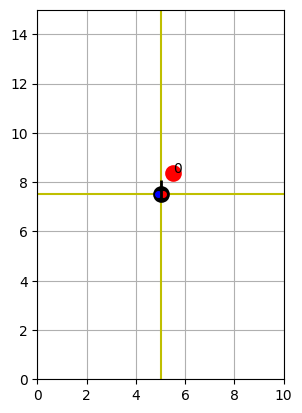

In [7]:
hlp.plot_scene(room,head_pos,head_orient,ears_pos,target_pos,perspective="xy")

In [ ]:
# -------------- SOUND FILES -----------------
# Noise in ambisonics:
noise_sig, fs_noise = sf.read(pjoin(arte_path,'09_Dinner_party_MOA_31ch.wav'))
noise_sig = sig.resample_poly(noise_sig, fs, fs_noise)
noise_sig = noise_sig[:chunk_len*fs] 
# pad noise signal to 121 channels 
zeropads=np.zeros([noise_sig.shape[0],121-31])
noise_sig =np.concatenate((noise_sig,zeropads),axis=1)

# Target in mono:
#target_sig, fs_targ = sf.read(pjoin(speech_path, 'esp_libri_speech_female_48k.wav'))
target_sig, fs_targ = sf.read(pjoin(speech_path, 'target1.wav'))
target_sig = np.squeeze(target_sig[:,0])
target_sig = sig.resample_poly(target_sig, fs, fs_targ)
# cut speech signal to the length of the noise (about 2 min)
target_sig=target_sig[:noise_sig.shape[0]]
target_sig=np.array(target_sig,ndmin=2)

# Target to SH
target_biSH = mono2biSH(target_sig, mic_rirs)
ane_target_biSH = mono2biSH(target_sig, ane_rirs)
target_sh = mono2sh(target_sig, mic_rirs)
ane_target_sh = mono2sh(target_sig, ane_rirs)
# crop all to equal length:
target_biSH = target_biSH[:, :chunk_len*fs]
ane_target_biSH = ane_target_biSH[:, :chunk_len*fs]
target_sh = target_sh[:chunk_len*fs]
ane_target_sh = ane_target_sh[:chunk_len*fs]

In [ ]:
# normalize the single soundfield case (for speaker reproduction)
ini_snr = 10 * np.log10(hlp.power(sh2bin(target_sh, decoder)) / hlp.power(sh2bin(noise_sig, decoder)))
target_snr = 5.
noise_gain_db = ini_snr - target_snr

In [ ]:
scaled_noise = noise_sig * np.power(10, noise_gain_db/20)
# normalize SH signals so that the binaural mixture is in [-1, 1] and it doesn't clip
norm_fact = np.max(np.abs(sh2bin(target_sh + scaled_noise, decoder)))

target_sh /= norm_fact
scaled_noise /= norm_fact
ane_target_sh /= norm_fact
if tag == 'inverse': 
    scaled_noise = -scaled_noise
mixture = target_sh + scaled_noise
reverb = target_sh - ane_target_sh

snr = 10 * np.log10(hlp.power(sh2bin(target_sh, decoder)) / hlp.power(sh2bin(scaled_noise, decoder)))

sf.write(pjoin(speech_path, f"{tag}_party_SH_deg{TARGET_ANGLE}_snr{int(target_snr)}_{fs}hz.wav"), mixture, fs, subtype='FLOAT')

Audio(sh2bin(mixture, decoder), rate=fs)

In [ ]:
# now we downmix to binaural only for listening purpose (combine single noise soundfield with two source soundfiels):
bin_noise = sh2bin(noise_sig, decoder)
bin_target = biSH2bin(target_biSH, decoder)
bin_ane = biSH2bin(ane_target_biSH, decoder)

bin_snr = 10 * np.log10(hlp.power(bin_target) / hlp.power(bin_noise))

noise_gain_db = bin_snr - target_snr

bin_noise = bin_noise * np.power(10, noise_gain_db/20)
norm_fact = np.max(np.abs(bin_noise + bin_target))


bin_noise /= norm_fact
bin_target /= norm_fact
bin_ane /= norm_fact

if tag == 'inverse': 
    bin_noise = -bin_noise
    
bin_mixture = bin_noise + bin_target
bin_reverb = bin_target - bin_ane

bin_mildmix = 0.25*bin_noise + 0.25*bin_reverb + bin_ane

In [ ]:
Audio(bin_mildmix, rate=fs)

In [ ]:
Audio(bin_ane, rate=fs)

In [ ]:
Audio(bin_target, rate=fs)

In [ ]:
Audio(bin_reverb, rate=fs)

In [ ]:
sf.write(pjoin(speech_path,f"{tag}_party_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_mixture_{fs}hz.wav"), bin_mixture.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_party_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_mildmix_{fs}hz.wav"), bin_mildmix.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_party_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_noise_{fs}hz.wav"), bin_noise.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_party_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_ane_{fs}hz.wav"), bin_ane.T, fs, subtype='FLOAT')

# SCENE 2: RESTAURANT

In [ ]:
# --------------- DESIGN SCENE ----------------
room = np.array([28., 17., 4.2]) 
rt60 = np.array([1.1]) * 0.5 # i feel this is too much... sounds like a cave
head_pos= np.array([room[0]/2, room[1]/2, 1.3]) # Listener coordinates
target_pos= hlp.place_on_circle(head_pos,1,TARGET_ANGLE)
head_orient = np.array([0, 0]) # Head rotation
ears_pos=hlp.head_2_ku_ears(head_pos,head_orient)

# --------------- COMPUTE ECHOGRAMS ----------------
# Compute absorption coefficients for desired rt60 and room dimensions
abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60)
# Small correction for sound absorption coefficients:
if sum(rt60_true-rt60>0.05*rt60_true)>0 :
    abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60_true + abs(rt60-rt60_true))
# Generally, we simulate up to RT60:
limits = np.minimum(rt60, maxlim)

mic = np.array([ears_pos[0], ears_pos[1], list(head_pos)]) #two positions for the binaural, one for the SH
src = np.array(target_pos)
nRec = mic.shape[0]
nSrc = src.shape[0]

# Compute the echograms, which means how many reflections, at what time and from which coordinates:
abs_echograms = srs.compute_echograms_sh(room, src, mic, abs_walls, limits, ambi_order, head_orient)
ane_echograms = hlp.crop_echogram(copy.deepcopy(abs_echograms))
# --------------- RENDER ECHOGRAMS ----------------
band_centerfreqs=np.array([1000])
mic_rirs = srs.render_rirs_sh(abs_echograms, band_centerfreqs, fs)
ane_rirs = srs.render_rirs_sh(ane_echograms, band_centerfreqs, fs)

In [ ]:
hlp.plot_scene(room,head_pos,head_orient,ears_pos,target_pos,perspective="xy")

In [ ]:
# -------------- SOUND FILES -----------------
# Noise in ambisonics:
noise_sig, fs_noise = sf.read(pjoin(speech_path, '07_Cafe_1_MOA_31ch.wav'))
noise_sig = sig.resample_poly(noise_sig, fs, fs_noise)
noise_sig = noise_sig[:chunk_len*fs] 
# pad noise signal to 121 channels 
zeropads=np.zeros([noise_sig.shape[0],121-31])
noise_sig =np.concatenate((noise_sig,zeropads),axis=1)

# Target in mono:
target_sig, fs_targ = sf.read(pjoin(speech_path, 'target1.wav'))
target_sig = np.squeeze(target_sig[:,0])
target_sig = sig.resample_poly(target_sig, fs, fs_targ)
# cut speech signal to the length of the noise (about 2 min)
target_sig=target_sig[:noise_sig.shape[0]]
target_sig=np.array(target_sig,ndmin=2)

# Target to SH
target_biSH = mono2biSH(target_sig, mic_rirs)
ane_target_biSH = mono2biSH(target_sig, ane_rirs)
target_sh = mono2sh(target_sig, mic_rirs)
ane_target_sh = mono2sh(target_sig, ane_rirs)
# crop all to equal length:
target_biSH = target_biSH[:, :chunk_len*fs]
ane_target_biSH = ane_target_biSH[:, :chunk_len*fs]
target_sh = target_sh[:chunk_len*fs]
ane_target_sh = ane_target_sh[:chunk_len*fs]

In [ ]:
# normalize the single soundfield case (for speaker reproduction)
ini_snr = 10 * np.log10(hlp.power(sh2bin(target_sh, decoder)) / hlp.power(sh2bin(noise_sig, decoder)))
target_snr = 5.
noise_gain_db = ini_snr - target_snr
    
scaled_noise = noise_sig * np.power(10, noise_gain_db/20)
# normalize SH signals so that the binaural mixture is in [-1, 1] and it doesn't clip
norm_fact = np.max(np.abs(sh2bin(target_sh + scaled_noise, decoder)))

target_sh /= norm_fact
scaled_noise /= norm_fact
ane_target_sh /= norm_fact
if tag == 'inverse': 
    scaled_noise = -scaled_noise
mixture = target_sh + scaled_noise  
reverb = target_sh - ane_target_sh

snr = 10 * np.log10(hlp.power(sh2bin(target_sh, decoder)) / hlp.power(sh2bin(scaled_noise, decoder)))


sf.write(pjoin(speech_path, f"{tag}_restaurant_SH_deg{TARGET_ANGLE}_snr{int(target_snr)}_{fs}hz.wav"), mixture, fs, subtype='FLOAT')
Audio(sh2bin(mixture, decoder), rate=fs)

In [ ]:
# now we downmix to binaural only for listening purpose (combine single noise soundfield with two source soundfiels):
bin_noise = sh2bin(noise_sig, decoder)
bin_target = biSH2bin(target_biSH, decoder)
bin_ane = biSH2bin(ane_target_biSH, decoder)

bin_snr = 10 * np.log10(hlp.power(bin_target) / hlp.power(bin_noise))

noise_gain_db = bin_snr - target_snr

bin_noise = bin_noise * np.power(10, noise_gain_db/20)
norm_fact = np.max(np.abs(bin_noise + bin_target))


bin_noise /= norm_fact
bin_target /= norm_fact
bin_ane /= norm_fact
if tag == 'inverse': 
    bin_noise = -bin_noise
bin_mixture = bin_noise + bin_target
bin_reverb = bin_target - bin_ane

bin_mildmix = 0.25*bin_noise + 0.25*bin_reverb + bin_ane

In [ ]:
Audio(bin_ane, rate=fs)

In [ ]:
Audio(bin_target, rate=fs)

In [ ]:
Audio(bin_reverb, rate=fs)

In [ ]:
sf.write(pjoin(speech_path,f"{tag}_restaurant_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_mixture_{fs}hz.wav"), bin_mixture.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_restaurant_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_mildmix_{fs}hz.wav"), bin_mildmix.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_restaurant_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_noise_{fs}hz.wav"), bin_noise.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_restaurant_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_ane_{fs}hz.wav"), bin_ane.T, fs, subtype='FLOAT')

# SCENE 3: MEETING

In [ ]:
# --------------- DESIGN SCENE ----------------
room = np.array([5., 2., 2.5]) 
rt60 = np.array([0.2]) * 0.6
head_pos= np.array([room[0]/2, room[1]/2, 1.3]) # Listener coordinates
target_pos= hlp.place_on_circle(head_pos,1,TARGET_ANGLE)
head_orient = np.array([0, 0]) # Head rotation
ears_pos=hlp.head_2_ku_ears(head_pos,head_orient)

# --------------- COMPUTE ECHOGRAMS ----------------
# Compute absorption coefficients for desired rt60 and room dimensions
abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60)
# Small correction for sound absorption coefficients:
if sum(rt60_true-rt60>0.05*rt60_true)>0 :
    abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60_true + abs(rt60-rt60_true))
# Generally, we simulate up to RT60:
limits = np.minimum(rt60, maxlim)

mic = np.array([ears_pos[0], ears_pos[1], list(head_pos)]) #two positions for the binaural, one for the SH
src = np.array(target_pos)
nRec = mic.shape[0]
nSrc = src.shape[0]

# Compute the echograms, which means how many reflections, at what time and from which coordinates:
abs_echograms = srs.compute_echograms_sh(room, src, mic, abs_walls, limits, ambi_order, head_orient)
ane_echograms = hlp.crop_echogram(copy.deepcopy(abs_echograms))
# --------------- RENDER ECHOGRAMS ----------------
band_centerfreqs=np.array([1000])
mic_rirs = srs.render_rirs_sh(abs_echograms, band_centerfreqs, fs)
ane_rirs = srs.render_rirs_sh(ane_echograms, band_centerfreqs, fs)

In [ ]:
hlp.plot_scene(room,head_pos,head_orient,ears_pos,target_pos,perspective="xy")

In [ ]:
# -------------- SOUND FILES -----------------
# Noise in ambisonics:
noise_sig, fs_noise = sf.read(pjoin(speech_path, '02_Office_MOA_31ch.wav'))
noise_sig = sig.resample_poly(noise_sig, fs, fs_noise)
noise_sig = noise_sig[:chunk_len*fs] 
# pad noise signal to 121 channels 
zeropads=np.zeros([noise_sig.shape[0],121-31])
noise_sig =np.concatenate((noise_sig,zeropads),axis=1)

# Target in mono:
target_sig, fs_targ = sf.read(pjoin(speech_path, 'target1.wav'))
target_sig = np.squeeze(target_sig[:,0])
target_sig = sig.resample_poly(target_sig, fs, fs_targ)
# cut speech signal to the length of the noise (about 2 min)
target_sig=target_sig[:noise_sig.shape[0]]
target_sig=np.array(target_sig,ndmin=2)

# Target to SH
target_biSH = mono2biSH(target_sig, mic_rirs)
ane_target_biSH = mono2biSH(target_sig, ane_rirs)
target_sh = mono2sh(target_sig, mic_rirs)
ane_target_sh = mono2sh(target_sig, ane_rirs)
# crop all to equal length:
target_biSH = target_biSH[:, :chunk_len*fs]
ane_target_biSH = ane_target_biSH[:, :chunk_len*fs]
target_sh = target_sh[:chunk_len*fs]
ane_target_sh = ane_target_sh[:chunk_len*fs]

In [ ]:
# normalize the single soundfield case (for speaker reproduction)
ini_snr = 10 * np.log10(hlp.power(sh2bin(target_sh, decoder)) / hlp.power(sh2bin(noise_sig, decoder)))
target_snr = 5.
noise_gain_db = ini_snr - target_snr
    
scaled_noise = noise_sig * np.power(10, noise_gain_db/20)
# normalize SH signals so that the binaural mixture is in [-1, 1] and it doesn't clip
norm_fact = np.max(np.abs(sh2bin(target_sh + scaled_noise, decoder)))

target_sh /= norm_fact
scaled_noise /= norm_fact
ane_target_sh /= norm_fact
if tag == 'inverse': 
    scaled_noise = -scaled_noise
mixture = target_sh + scaled_noise 
reverb = target_sh - ane_target_sh

snr = 10 * np.log10(hlp.power(sh2bin(target_sh, decoder)) / hlp.power(sh2bin(scaled_noise, decoder)))

sf.write(pjoin(speech_path, f"{tag}_meeting_SH_deg{TARGET_ANGLE}_snr{int(target_snr)}_{fs}hz.wav"), mixture, fs, subtype='FLOAT')

Audio(sh2bin(mixture, decoder), rate=fs)

In [ ]:
# now we downmix to binaural only for listening purpose (combine single noise soundfield with two source soundfiels):
bin_noise = sh2bin(noise_sig, decoder)
bin_target = biSH2bin(target_biSH, decoder)
bin_ane = biSH2bin(ane_target_biSH, decoder)

bin_snr = 10 * np.log10(hlp.power(bin_target) / hlp.power(bin_noise))

noise_gain_db = bin_snr - target_snr

bin_noise = bin_noise * np.power(10, noise_gain_db/20)
norm_fact = np.max(np.abs(bin_noise + bin_target))


bin_noise /= norm_fact
bin_target /= norm_fact
bin_ane /= norm_fact
if tag == 'inverse': 
    bin_noise = -bin_noise
bin_mixture = bin_noise + bin_target
bin_reverb = bin_target - bin_ane

bin_mildmix = 0.25*bin_noise + 0.25*bin_reverb + bin_ane

In [ ]:
Audio(bin_ane, rate=fs)

In [ ]:
Audio(bin_target, rate=fs)

In [ ]:
Audio(bin_reverb, rate=fs)

In [ ]:
sf.write(pjoin(speech_path,f"{tag}_meeting_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_mixture_{fs}hz.wav"), bin_mixture.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_meeting_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_mildmix_{fs}hz.wav"), bin_mildmix.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_meeting_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_noise_{fs}hz.wav"), bin_noise.T, fs, subtype='FLOAT')
sf.write(pjoin(speech_path,f"{tag}_meeting_bin_deg{TARGET_ANGLE}_snr{int(target_snr)}_ane_{fs}hz.wav"), bin_ane.T, fs, subtype='FLOAT')